# 4.1- AB Testing

![ab_test](images/ab_test.png)


### Guía paso a paso

Veremos todo el proceso de un test AB, desde formular la hipótesis, ponerla a prueba y finalmente interpretar los resultados. Usaremos los datos de [Kaggle](https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv) que continen los resultados de un test AB de dos posibles paginas webs (la version vieja y la nueva)

El proceso será como sigue:

1. [Diseñar el experimento](#1.-Diseñar-el-experimento)
2. [Obtener y preparar datos](#2.-Obtener-y-preparar-datos)
3. [Visualizar los resultados](#3.-Visualizar-los-resultados)
4. [Testear la hipótesis](#4.-Testear-la-hipótesis)
5. [Interpretar resultados](#5.-Interpretar-resultados)

Para contextualizar, imaginemos el siguiente caso de estudio:

![abtest](images/abtest.jpg)

> Trabajamos en el equipo de producto de una **compañia de e-commerce online**. El equipo de UX está trabajando muy duro en la nueva versión de la página del producto, con el objetivo de alcanzar tasas de conversión más altas. El PM (product manager) nos dice que la versión actual de la página consigue una **tasa de conversión del 13% de media anual**. El objetivo anual es un **incremento del 2%**, lo que implica que la nueva versión debe alcanzar el 15% de tasa de conversión.

Antes de realizar el cambio definitivo de la página, es necesario realizar pruebas para comprobar que realmente funciona. Es en ese momento donde aparece el **test AB** realizado sobre un conjunto de usuarios.

***
### 1. Diseñar el experimento


#### Formulando una hipótesis

Realizada la observación de la necesidad de un test, es necesario plantear una hipótesis. Dado que no sabemos si la nueva página funciona mejor o peor, usaremos el [test de dos colas](https://en.wikipedia.org/wiki/One-_and_two-tailed_tests):

$$H_0: p = p_0$$
$$H_1: p \ne p_0$$

donde $p$ y $p_0$ son las tasas de conversión del nuevo diseño de la web y el viejo diseño respectivamente. Además, establecemos un **intervalo de confianza del 95%**:

$$\alpha = 0.05$$

El valor de $\alpha$ es el umbral para ese intervalo de confianza, que lo que quiere decir es que "si la probabilidad de observar un resultado, el $p$-valor, es menor que $\alpha$, entonces podemos rechazar la hipótesis nula". Nuestro $\alpha=0.05$ indica un 5% de probabilidad, dando un intervalo de confianza, 1 - $\alpha$, del 95%.



#### Escogiendo las variables

Para nuestro test necesitamos **dos grupos**:
* Un grupo de `control` - Será el grupo que vea el viejo diseño de la web
* Un grupo de `tratamiento`, o experimental - Será el grupo que vea el nuevo diseño de la página

Esta será nuestra *variable independiente*. La razón de tener dos grupos aun cuando ya sabemos la tasa de conversión actual, es que queremos controlar otras variables que podrían afectar los resultados, como la estacionalidad. Teniendo un grupo de `control` podemos comparar directamente los resultados con el grupo de `tratamiento`, porque la única diferencia sistemática entre los dos grupos es el diseño de la página web del producto, y podemos asumir la diferencia entre ellos debido a ese diseño.

La *variable dependiente*, la que tratamos de medir, es la `tasa de conversion`. Una manera de registrarla es a través de un registro binario:
* `0` - Usuario que no compra durante su visita a la web.
* `1` - Usuario que compra en la web.




#### Escogiendo el tamaño de la muestra

Es importante remarcar que no vamos a hacer el test en toda nuestra base de datos, por lo que en realidad lo que obtendremos serán estimaciones. El número de personas, o de sesiones, que decidamos capturar de cada grupo tendrá un efecto sobre la estimación de nuestras tasas de conversión. Cuanto más grande sea la muestra, más precisión tendrá nuestra estimación, y cuanto más precisa sea nuestra estimación más altas serán las posibilidades de detectar diferencias entre grupos si existieran.

Por otro lado, cuanto más grande sea la muestra más caro e impracticable se vuelve el estudio.

*Asi que, ¿cuánta gente debería haber en cada grupo?*

Para estimar el tamaño en este caso, usaremos lo que se conoce potencia de una prueba estadística o el [poder estadístico](https://es.wikipedia.org/wiki/Poder_estad%C3%ADstico), que depende de varios valores: 

* **Poder del test** ($1 - \beta$) - Representa la probabilidad de encontrar una diferencia estadísticamente significativa entre los grupos. Por convenio se suele establecer en 0.8

* **Umbral (p-valor)** ($\alpha$) - Valor crítico establecido anteriormente en 0.05

* **Tamaño del efecto** - Como de grande es la diferencia esperada entre las tasas de conversión. Nuestro objetivo era el 2%

In [1]:
# librerias

import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.stats.api as sms

import pylab as plt
import seaborn as sns

%matplotlib inline

https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.solve_power.html

In [2]:
# calculo el tamaño del efecto. del 13% al 15%

efecto=sms.proportion_effectsize(0.13, 0.15)

efecto

-0.0576728617308947

In [12]:
# tamaño de la muestra

n_requerido=sms.NormalIndPower().solve_power(efecto, 
                                              power=0.8, 
                                              alpha=0.05)

n_requerido

4719.4740575998185

Necesitamos **al menos 4720 observaciones para cada grupo**. 

Establecer el `poder estadístico` en 0.8 implica que si existe una diferencia significativa entre las tasas de conversión, tenemos un 80% de probabilidad de detectarla con este tamaño de la muestra.

***
### 2. Obtener y preparar datos


Obtenemos el dataframe y procedemos a examinarlos y prepararlos para el estudio. Escogeremos una muestra aleatoria de 4720 registros por cada grupo.

In [13]:
df=pd.read_csv('../data/ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [15]:
pd.crosstab(df.group, df.landing_page)

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


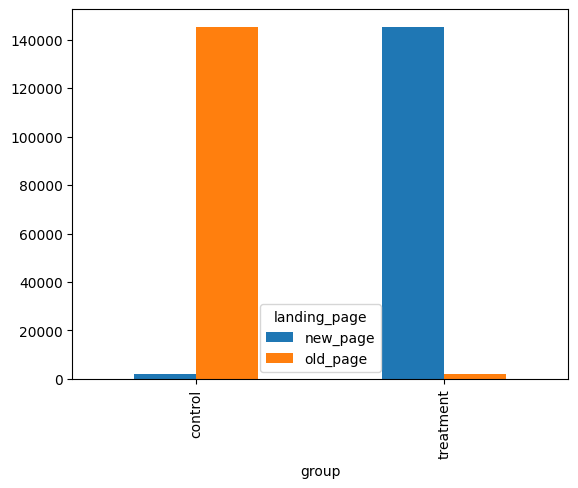

In [16]:
pd.crosstab(df.group, df.landing_page).plot(kind='bar');

In [19]:
df.shape

(294478, 5)

Eliminamos usuarios con varias visitas a la página web.

In [17]:
sesiones=df.user_id.value_counts(ascending=False)

sesiones[sesiones>1].count()

3894

In [20]:
drop_usuarios=sesiones[sesiones>1].index

df=df[~df.user_id.isin(drop_usuarios)]

df.shape

(286690, 5)

In [21]:
pd.crosstab(df.group, df.landing_page)

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


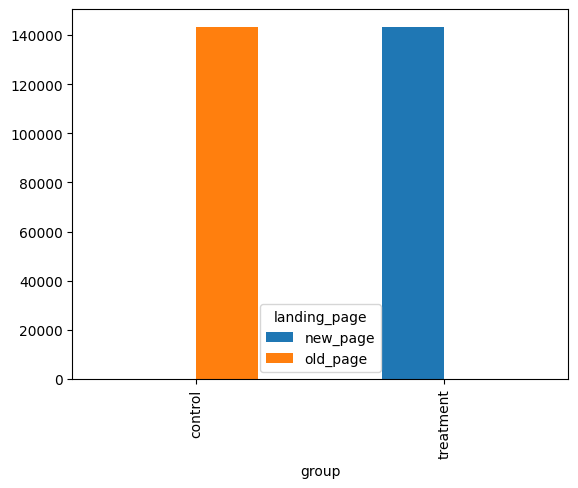

In [22]:
pd.crosstab(df.group, df.landing_page).plot(kind='bar');

**Muestreo**

In [23]:
control=df[df.group=='control'].sample(n=4720, random_state=22)

tratamiento=df[df.group=='treatment'].sample(n=4720, random_state=22)

ab_test=pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0


In [24]:
ab_test.tail()

,user_id,timestamp,group,landing_page,converted
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0
9439,944623,2017-01-19 10:56:01.648653,treatment,new_page,1


In [25]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [26]:
ab_test.group.value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

Ya tenemos las muestras que necesitamos para realizar el estudio.

***
### 3. Visualizar los resultados

Realizamos algunos cálculos descriptivos:

In [27]:
tasas_conversion=ab_test.groupby('group')['converted']  # agrupo por grupo



std=lambda x: np.std(x, ddof=0)    # std
error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))



tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}')

,conversion_rate,std,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


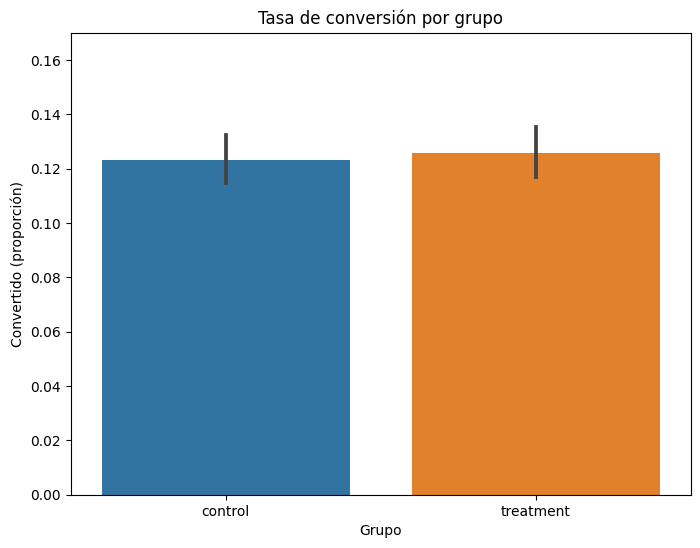

In [28]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], 
            y=ab_test['converted'])

plt.ylim(0, 0.17)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

Las tasas de conversión para ambos grupos están muy cerca. La tasa de conversión del grupo de  `control` es menor que la esperada (12.3% vs 13% que nos habían dicho).

Asi que el grupo de `tratamiento` tiene una tasa de conversión mayor. **¿Es esta diferencia estadísticamente significativa?**

***
### 4. Testear la hipótesis

El último paso es testear nuestra hipótesis. Tenemos una muestra suficiente para usar el z-test. 

Podemos usar `statsmodels.stats.proportion` para obtener los $p$-valores y los intervalos de confianza:

***
### 5. Interpretar resultados

Dado que el $p$-valor=0.732 es mayor que $\alpha$=0.05, no podemos rechazar la hipótesis nula $H_0$, lo que significa que el nuevo diseño de la página no tiene un rendimiento significativamente diferente del viejo diseño.

Adicionalmente, si se observa el intervalo de confianza para el grupo de  `tratamiento`([0.116, 0.135], i.e. 11.6-13.5%) nos damos cuenta de que:
1. Incluye nuestro valor base del 13% en la tasa de conversion
2. No incluye nuestro valor objetivo del 15% (el 2% de subida que buscabamos)

Todo esto implica que lo más probable es que la tasa de conversión del nuevo diseño sea similar al viejo diseño de la web, y no llegaría a ese 15% buscado. Esto probaría que el diseño no mejora nuestra tasa de conversión y que habría que volver a la mesa de diseño.